# House price prediction for Denver Dataset

In this case (Part II), there are two main tasks:

- First, you will need to split the train data into train and validate data and tune the model hyperparameters to choose the best model. Submit the predicted prices for test data to Kaggle to compete for Prof. X's Prize!

- Then you will examine the profit of the iBuyer business model based on the predicted price on the valid data.






You need to submit a report in pdf format containing the following material on canvas site:

1.   A plot of the training errors and validation errors over epochs for a base multilayer perceptron model with 2 hidden layers of sizes 256 and 128.

2.   A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64.

3.  A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64
and norm regularization.

4. A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64
and norm regularization and dropout layers.

5. A table listing all the model hyperparameters that you have tried with the corresponding validation errors that you found.

6. Your profit analysis of the the iBuyer business model based on the predicted price on the valid data and answers to the four questions therein.


You also need to submit on canvas site:

- The complete Juyputer notebook containing all your Pytorch code with explanations, along with a Markdown text explaining different parts if needed.
-  A checkpoint.pth file containing all the necessary information to retrieve your best model and predictions.



---
## Data Loading and Visualize Data

The train data and test data are available on Kaggle website.
You can first download them, then upload them to the google colab, and then read the data using pandas.

In [72]:
import pandas as pd  # Importing pandas, which is a library for data manipulation and analysis
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch
from numpy.ma.core import absolute
import math


#TODO: Read the datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [73]:
# Display the train dataframe
print(train_df.shape)
print(train_df.columns)

(11581, 17)
Index(['ID', 'NBHD', 'PROP_CLASS', 'LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA',
       'LAND_SQFT', 'GRD_AREA', 'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B',
       'HLF_B', 'STORY', 'STYLE_CN', 'UNITS', 'SALE_PRICE'],
      dtype='object')


In [74]:
# Display the test dataframe
print(test_df.shape)
print(test_df.columns)

(4964, 16)
Index(['ID', 'NBHD', 'PROP_CLASS', 'LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA',
       'LAND_SQFT', 'GRD_AREA', 'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B',
       'HLF_B', 'STORY', 'STYLE_CN', 'UNITS'],
      dtype='object')


As you can see, we have 11581 training samples and 4964 test samples, each with 16 features. The training samples contain the sale_prices, which are the labels. The test samples do not contain the sale_prices, which we will predict by building a MLP model.


### Visualization of SALE PRICES

Let's take a closer look at the sale prices in the train data.

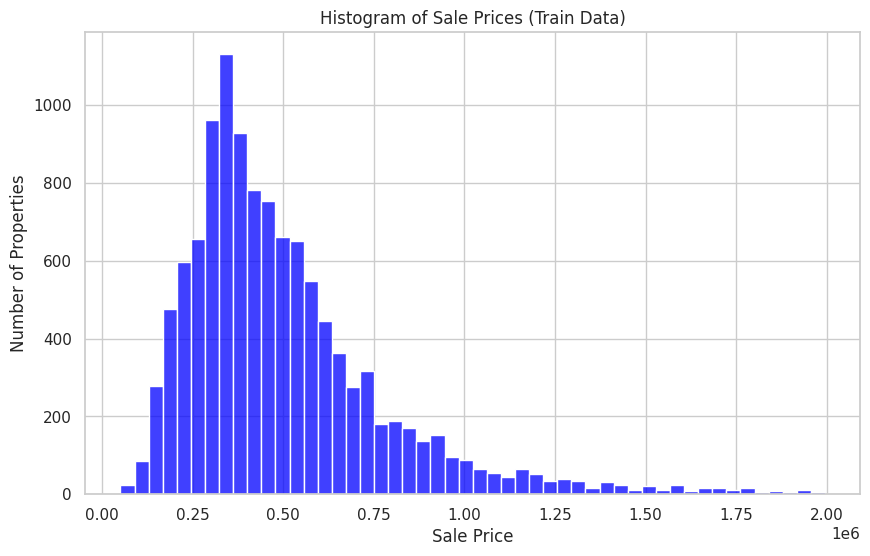

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt  # Importing matplotlib's pyplot, it provides a MATLAB-like interface for making plots and charts

# Set the style
sns.set(style="whitegrid")

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SALE_PRICE'], bins=50, color='blue')
plt.title('Histogram of Sale Prices (Train Data)')
plt.xlabel('Sale Price')
plt.ylabel('Number of Properties')
plt.show()

Check the minimum and maximum sale_price in train data.

In [76]:
print(train_df['SALE_PRICE'].min())
print(train_df['SALE_PRICE'].max())
print(train_df['SALE_PRICE'].median())

51000
1995000
431000.0


We see that the sale_price has a wide range from 50K to 2 million, with the median price 431K.

### Visualization of Correlation

We can also compute and visualize the correlation matrix.

<ipython-input-77-28da14c2e215>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


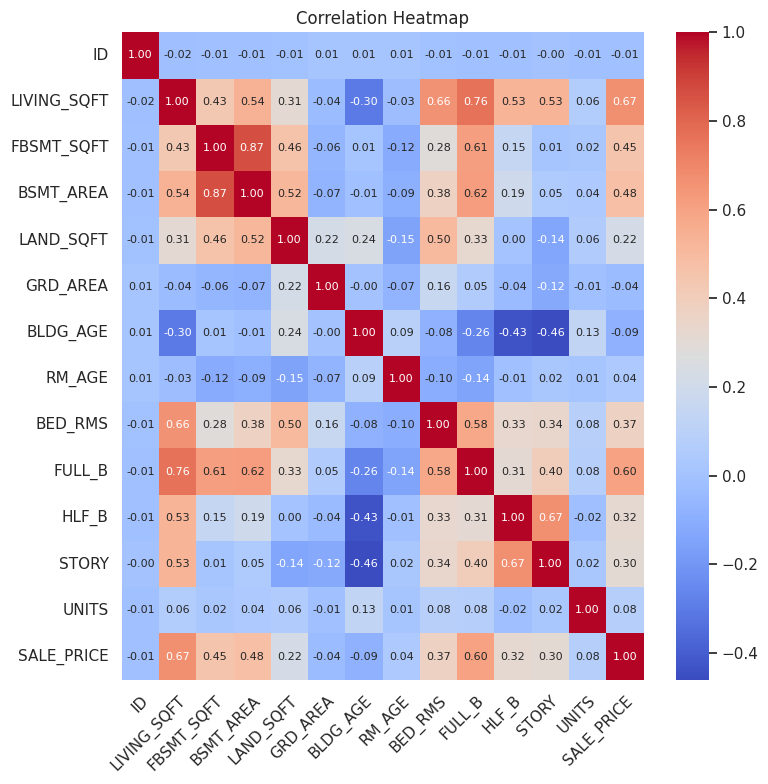

In [77]:
# Compute the correlation matrix:
correlation_matrix = train_df.corr()

# 1. Increase the figure size for clarity
plt.figure(figsize=(8, 8))

# 2. Use a heatmap with annotations, a color map, and specific formatting for the annotations
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})

# 3. Rotate the x-axis labels for better visibility
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Rotate the y-axis labels
plt.setp(ax.get_yticklabels(), rotation=0)

# 4. Title and display
plt.title('Correlation Heatmap')
plt.tight_layout()  # This can help if any labels are still being cut off
plt.show()

# 5. Optionally save the figure with high resolution
# plt.savefig("heatmap.png", dpi=300)

We can see that the Sale_Price has high correlation with Living_SQFT and number of Full Bathrooms.

### Distribution of houses over different NBHD

In [78]:
# Compute the number of houses per neighborhood
House_by_NBHD = train_df['NBHD'].value_counts()
print(House_by_NBHD )

CENTRAL PARK                    1049
GATEWAY / GREEN VALLEY RANCH     937
UNION STATION                    369
HAMPDEN                          346
WINDSOR                          316
                                ... 
VALVERDE                          22
GLOBEVILLE                        20
SUN VALLEY                         8
CORY - MERRILL                     4
AURARIA                            1
Name: NBHD, Length: 75, dtype: int64


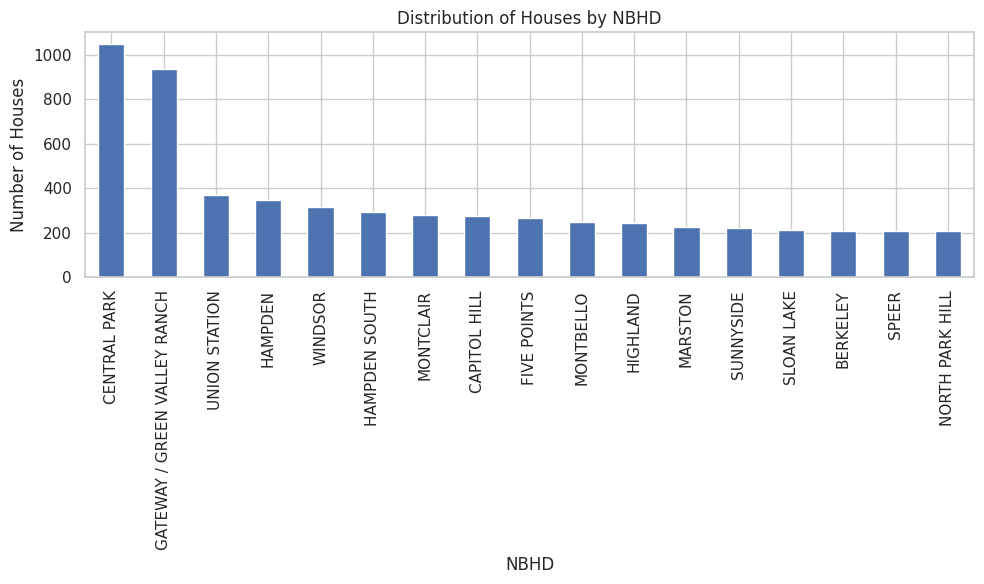

In [79]:
# Filtering ZIP codes that appear more than once
filtered_House_by_NBHD = House_by_NBHD[House_by_NBHD > 200]
filtered_House_by_NBHD.plot(kind='bar', figsize=(10,6))
plt.title('Distribution of Houses by NBHD')
plt.ylabel('Number of Houses')
plt.xlabel('NBHD')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability, if necessary
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()


---
## Data Preparation

The first step when building a neural network model is getting your data into the proper form to feed into the network.

- Train labels: We need to extract the sale prices from the train data as train labels. Since the house prices can take very large values, to make training fast it is helpful to define the train labels as the sale prices divided by a normalization factor.

- **Handing non-numeric features**: Some of the house features are non-numeric. We will learn about how to process categorical data in the upcoming lectures. For now, you can  remove those non-numeric features and only train over the numeric features.

- **Feature standardization**: When predicting house prices, you started from features that took a variety of ranges—some features had small floating-point values, and others had fairly large integer values. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice for dealing with such data is to do feature-wise normalization: for each feature in the input data (a column in the input dataframe), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has
a unit standard deviation. Note that here we combine the feature vectors in the train and test data. In this way, the train and test data go through the same normalization.

- **Handling missing values**: There may exist some entries with missing values. After the feature standardization, we can impute the missing values with zeros.

In [80]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4964 entries, 0 to 4963
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           4964 non-null   int64  
 1   NBHD         4964 non-null   object 
 2   PROP_CLASS   4964 non-null   object 
 3   LIVING_SQFT  4964 non-null   int64  
 4   FBSMT_SQFT   4964 non-null   int64  
 5   BSMT_AREA    4964 non-null   int64  
 6   LAND_SQFT    4964 non-null   int64  
 7   GRD_AREA     4964 non-null   int64  
 8   BLDG_AGE     4964 non-null   int64  
 9   RM_AGE       2623 non-null   float64
 10  BED_RMS      4964 non-null   float64
 11  FULL_B       4964 non-null   float64
 12  HLF_B        4964 non-null   int64  
 13  STORY        4964 non-null   float64
 14  STYLE_CN     4964 non-null   object 
 15  UNITS        4964 non-null   float64
dtypes: float64(5), int64(8), object(3)
memory usage: 620.6+ KB


We see that the sale_price in train data has a wide range from 50K to 2 million, with the median price 431K. We can divide the sale_price by 100K, so the normalized sale_price is between 0.5 and 20 in training data. Remember, when we output the predicted price for the test data, we need to multiply back the normalization factor.

In [81]:
#TODO: define labels for train data
normalization_factor=100000
train_labels = train_df['SALE_PRICE']/normalization_factor
train_df.drop('SALE_PRICE', axis=1, inplace=True) # drop the sale_prices in features.

The inplace parameter, when set to True , allows you to drop the rows or columns without returning a new DataFrame. The issue arises when the drop function reorders the DataFrame, which can be problematic when the order of your data matters

Note that both the training samples and test samples contain an ID column, which is not informative for predicting the house price. Thus we will drop the ID column.

In [82]:
train_ID=train_df['ID']
test_ID=test_df['ID']
train_df.drop('ID', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)

In [83]:
# Then we combine the feature vectors in the train data and test data
features=pd.concat(objs=[train_df,test_df],axis=0)

In [84]:
# median = features["RM_AGE"].median()
# features = features.fillna(median)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16545 entries, 0 to 4963
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NBHD         16545 non-null  object 
 1   PROP_CLASS   16545 non-null  object 
 2   LIVING_SQFT  16545 non-null  int64  
 3   FBSMT_SQFT   16545 non-null  int64  
 4   BSMT_AREA    16545 non-null  int64  
 5   LAND_SQFT    16545 non-null  int64  
 6   GRD_AREA     16545 non-null  int64  
 7   BLDG_AGE     16545 non-null  int64  
 8   RM_AGE       8705 non-null   float64
 9   BED_RMS      16545 non-null  float64
 10  FULL_B       16545 non-null  float64
 11  HLF_B        16545 non-null  int64  
 12  STORY        16545 non-null  float64
 13  STYLE_CN     16545 non-null  object 
 14  UNITS        16545 non-null  float64
dtypes: float64(5), int64(7), object(3)
memory usage: 2.0+ MB


We see that there are three non-numeric features, namely `NBHD`, `PROP_CLASS`, and `STYLE_CN`. We will apply one-hot encoding to those non-numeric features in our model; you could also simply drop these non-numeric features.

In [85]:
# numeric_features = features.dtypes[features.dtypes != 'object'].index
# non_numeric_features = features.dtypes[features.dtypes == 'object'].index
# numeric_features, non_numeric_features

numeric_features = ["LIVING_SQFT", "FBSMT_SQFT", "BSMT_AREA", "LAND_SQFT", "GRD_AREA", "BLDG_AGE", "RM_AGE", "BED_RMS"]
non_numeric_features = ['NBHD', 'PROP_CLASS', 'STYLE_CN', "FULL_B", "HLF_B", "STORY", "UNITS"]

In [86]:
# If you want to drop the non-numeric features, you just set drop_non_numeric_features= True.
drop_non_numeric_features= False

if drop_non_numeric_features:
    features= features.drop(non_numeric_features, axis=1)
else:
    # One-hot encode categorical features
    features = pd.get_dummies(features, columns=non_numeric_features, dummy_na=True, drop_first=True)

# Check for non-numeric columns
non_numeric_cols = features.select_dtypes(include=['object']).columns
if not non_numeric_cols.empty:
    raise ValueError(f"DataFrame contains non-numeric columns: {non_numeric_cols.tolist()}")

In [87]:
# # Standardize numeric features
features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))


In [88]:
# recheck the mean and std after standardization
features[numeric_features].mean(), features[numeric_features].std()

(LIVING_SQFT   -6.919686e-17
 FBSMT_SQFT    -7.907445e-17
 BSMT_AREA      5.829929e-17
 LAND_SQFT      1.792998e-17
 GRD_AREA      -1.975519e-17
 BLDG_AGE      -1.385011e-17
 RM_AGE         2.795645e-17
 BED_RMS        2.122341e-16
 dtype: float64,
 LIVING_SQFT    1.0
 FBSMT_SQFT     1.0
 BSMT_AREA      1.0
 LAND_SQFT      1.0
 GRD_AREA       1.0
 BLDG_AGE       1.0
 RM_AGE         1.0
 BED_RMS        1.0
 dtype: float64)

We see that after standardization, the features for the train data have mean 0 and standard deviation 1.

In [89]:
# After the feature standardization, we can impute the missing values with zeros.
features[numeric_features] = features[numeric_features].fillna(3)

Double check the features after data processing.

In [90]:
features.info()
print(features.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16545 entries, 0 to 4963
Columns: 122 entries, LIVING_SQFT to UNITS_nan
dtypes: float64(8), uint8(114)
memory usage: 2.9 MB
Index(['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA',
       'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'NBHD_AURARIA', 'NBHD_BAKER',
       ...
       'STORY_2.5', 'STORY_3.0', 'STORY_3.5', 'STORY_4.0', 'STORY_nan',
       'UNITS_2.0', 'UNITS_3.0', 'UNITS_4.0', 'UNITS_5.0', 'UNITS_nan'],
      dtype='object', length=122)


In [91]:
print(features.columns.tolist())

['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA', 'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'NBHD_AURARIA', 'NBHD_BAKER', 'NBHD_BARNUM', 'NBHD_BARNUM WEST', 'NBHD_BEAR VALLEY', 'NBHD_BELCARO', 'NBHD_BERKELEY', 'NBHD_CAPITOL HILL', 'NBHD_CBD', 'NBHD_CENTRAL PARK', 'NBHD_CHAFFEE PARK', 'NBHD_CHEESMAN PARK', 'NBHD_CHERRY CREEK', 'NBHD_CITY PARK', 'NBHD_CIVIC CENTER', 'NBHD_CLAYTON', 'NBHD_COLE', 'NBHD_COLLEGE VIEW / SOUTH PLATTE', 'NBHD_CONGRESS PARK', 'NBHD_CORY - MERRILL', 'NBHD_COUNTRY CLUB', 'NBHD_DIA', 'NBHD_EAST COLFAX', 'NBHD_ELYRIA SWANSEA', 'NBHD_FIVE POINTS', 'NBHD_FORT LOGAN', 'NBHD_GATEWAY / GREEN VALLEY RANCH', 'NBHD_GLOBEVILLE', 'NBHD_GOLDSMITH', 'NBHD_HAMPDEN', 'NBHD_HAMPDEN SOUTH', 'NBHD_HARVEY PARK', 'NBHD_HARVEY PARK SOUTH', 'NBHD_HIGHLAND', 'NBHD_HILLTOP', 'NBHD_INDIAN CREEK', 'NBHD_JEFFERSON PARK', 'NBHD_LINCOLN PARK', 'NBHD_LOWRY FIELD', 'NBHD_MAR LEE', 'NBHD_MARSTON', 'NBHD_MONTBELLO', 'NBHD_MONTCLAIR', 'NBHD_NORTH CAPITOL HILL', 'NBHD_NORTH PARK HILL', 'NBH

Note that after the one-hot encoding of the non-numeric features, now we have 105-dimensional feature.

In [92]:
# check whether there is any missing entry
print(features.isnull().sum())
any_na_train = features.isna().any().any()
any_na_test = features.isna().any().any()
any_na_train, any_na_test

LIVING_SQFT    0
FBSMT_SQFT     0
BSMT_AREA      0
LAND_SQFT      0
GRD_AREA       0
              ..
UNITS_2.0      0
UNITS_3.0      0
UNITS_4.0      0
UNITS_5.0      0
UNITS_nan      0
Length: 122, dtype: int64


(False, False)

In [93]:
# we extract out the train and test features
train_features = features.iloc[:len(train_labels)]
test_features = features.iloc[len(train_labels):]
train_features.shape, test_features.shape

((11581, 122), (4964, 122))

In [94]:
train_features.describe()

,LIVING_SQFT,FBSMT_SQFT,BSMT_AREA,LAND_SQFT,GRD_AREA,BLDG_AGE,RM_AGE,BED_RMS,NBHD_AURARIA,NBHD_BAKER,...,STORY_2.5,STORY_3.0,STORY_3.5,STORY_4.0,STORY_nan,UNITS_2.0,UNITS_3.0,UNITS_4.0,UNITS_5.0,UNITS_nan
count,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000,...,11581.000000,11581.000000,11581.000000,11581.000000,11581.0,11581.000000,11581.000000,11581.000000,11581.000000,11581.0
mean,0.001135,0.007718,0.005795,-0.001391,-0.006033,-0.001530,1.428523,-0.003048,0.000086,0.005613,...,0.013643,0.074778,0.000173,0.002590,0.0,0.010707,0.001468,0.000863,0.000086,0.0
std,0.995964,1.008507,1.003702,1.001205,0.979752,0.999297,1.662331,0.997300,0.009292,0.074710,...,0.116009,0.263044,0.013141,0.050833,0.0,0.102925,0.038287,0.029374,0.009292,0.0
min,-1.603269,-0.692044,-0.823130,-1.139796,-0.167508,-1.212487,-0.760084,-2.720517,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,-0.706367,-0.692044,-0.823130,-1.139796,-0.167508,-0.977104,-0.508553,-0.498851,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
50%,-0.256510,-0.692044,-0.823130,-0.094746,-0.167508,0.016736,1.755230,-0.498851,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.435145,0.863088,0.811911,0.669500,-0.167508,0.618270,3.000000,0.611982,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
max,7.531639,6.212484,7.196703,9.542289,14.542084,2.501334,8.923876,6.166148,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0


In [95]:
import torch
import numpy as np

# Convert training features and labels to PyTorch tensors
train_features = torch.tensor(train_features.values.astype(np.float32), dtype=torch.float32)
test_features = torch.tensor(test_features.values.astype(np.float32), dtype=torch.float32)
train_labels = torch.tensor(train_labels.values.reshape(-1, 1).astype(np.float32), dtype=torch.float32)

In [96]:
train_labels

tensor([[ 2.8500],
        [12.3000],
        [ 4.2000],
        ...,
        [ 6.0200],
        [ 3.8370],
        [ 5.5000]])

In [97]:
train_features.shape, train_labels.shape

(torch.Size([11581, 122]), torch.Size([11581, 1]))

---
## Training and Validation

To prevent overfitting, we'll split it our training data into training and validation. We will use validation set to select the appropriate model.
One way is to use the [`train_test_split` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). You're more than welcome to use your own way.

In [98]:
#TODO: filling in the missing code to split train data into train and validation
from sklearn.model_selection import train_test_split  # Importing train_test_split function from sklearn for splitting data into training set and validation set
# Splitting the training data: 20% is validation data
ultimate_train_features = train_features
ultimate_train_labels = train_labels


train_indices, valid_indices = train_test_split(
    range(len(train_features)),
    test_size= 0.1,
    random_state=10
)

train_features_split = train_features[train_indices]
train_labels_split = train_labels[train_indices]
valid_features_split = train_features[valid_indices]
valid_labels_split = train_labels[valid_indices]

train_features, train_labels, valid_features, valid_labels = train_features[train_indices], train_labels[train_indices], train_features[valid_indices], train_labels[valid_indices]



In [99]:
print(train_features.shape)
print(valid_features.shape)
print(train_labels.shape)
print(valid_labels.shape)

torch.Size([10422, 122])
torch.Size([1159, 122])
torch.Size([10422, 1])
torch.Size([1159, 1])


---
## DataLoaders and Batching

After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:
1. Create a known format for accessing our data, using [TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2. Create DataLoaders and batch our training, validation, and test Tensor datasets. Note that we will shuffle the train data, so the model will not learn a particular order. For valid and test data, we do not shuffle.

In [29]:
from torch.utils.data import TensorDataset, DataLoader
train_data = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
#TODO: create dataloader for validation data
valid_data = TensorDataset(valid_features, valid_labels)
valid_loader = DataLoader(valid_data, batch_size = 16, shuffle = False)

In [30]:
test_data = TensorDataset(test_features)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

ultimate_train_data = TensorDataset(ultimate_train_features, ultimate_train_labels)
ultimate_train_loader = DataLoader(ultimate_train_data, batch_size = 16, shuffle = True)

Let's take a batch to have a sanity check

In [31]:
# obtain one batch of training data
dataiter = iter(train_loader)
features, labels = next(dataiter)

print('Sample input size: ', features.size()) # batch_size, seq_length
print('Sample input: \n', features)
print()
print('Sample label size: ', labels.size()) # batch_size
print('Sample label: \n', labels)

Sample input size:  torch.Size([16, 122])
Sample input: 
 tensor([[ 0.7500, -0.6920,  0.9583,  ...,  0.0000,  0.0000,  0.0000],
        [-0.8132, -0.6920, -0.8231,  ...,  0.0000,  0.0000,  0.0000],
        [-0.8821, -0.6920, -0.8231,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8737, -0.6920, -0.8231,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0527, -0.6920, -0.8231,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1272,  0.6114,  0.3295,  ...,  0.0000,  0.0000,  0.0000]])

Sample label size:  torch.Size([16, 1])
Sample label: 
 tensor([[ 3.8000],
        [ 2.7500],
        [ 4.2554],
        [ 6.0500],
        [ 2.1500],
        [11.5000],
        [ 1.8378],
        [ 7.6000],
        [ 6.9500],
        [ 3.5500],
        [ 5.2032],
        [ 1.5000],
        [ 1.7400],
        [ 1.5700],
        [ 5.6500],
        [ 3.7700]])


---
## Linear Regression as Benchmark

Let us build a linear regression model as a benchmark. Note that the linear regression model can be viewed as a special instance of multi-layer perception with no hidden layer and a single output neuron.

In [32]:
# Build a linear regression model network
lin_net = nn.Linear(train_features.shape[1], 1)

Let's print out the model achitecture.

In [33]:
lin_net

Linear(in_features=122, out_features=1, bias=True)

Let's take a batch and see the output

In [34]:
features, labels = next(dataiter)
output=lin_net(features)
output.shape,labels.shape

(torch.Size([16, 1]), torch.Size([16, 1]))

---
## Train the model

First, we will use GPU training if it is availabe.

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lin_net = lin_net.to(device)
print(f"Using gpu: {torch.cuda.is_available()}")

Using gpu: True


Second, let us specify the loss function.

In [36]:
#Since both the output and the label are real valued, we will use the standard mean-squared loss.
criterion_MSE = nn.MSELoss()

class MER(nn.Module):
  def __init__(self):
    super(MER, self).__init__()
  def forward(self, output, labels):
    return torch.median(torch.abs((output-labels)/labels))

criterion_MER = MER()

Third, while we are using the mean-squared loss for training loss, we will use
a different metric to measure the predictive performance.

Note that with house prices, as with stock prices, we care about relative quantities more than absolute quantities. Thus we tend to care more about the relative error than about the absolute error. For instance, if our prediction is off by \\$100,000 when estimating the sale price of a house which is \\$125,000, then we are probably doing a horrible job. On the other hand, if we err by this amount for a house with sale price \\$2 million, this might represent a pretty  accurate prediction.

To address this issue, we will use the median error rate (MER) used by [Zestimate](https://www.zillow.com/z/zestimate/) to measure the predictive performance. The error rate is defined as
$$
\text{Error Rate} = \left| \frac{\text{Predicted Price}-\text{Actual Price}}{\text{Actual Price}} \right|
$$
The median error rate is defined as the median of error rates for all properties.

Define functions for training purposes

In [37]:
def train_dynamic(model, epochs, lr, criterion, train_loader, valid_loader, patience, weight=None, device='cuda'):
    model.to(device)
    model.train()

    if weight is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight)

    # Dynamic learning rate
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience//2, factor=0.1, verbose=True)

    # Early Stopping
    the_last_loss = np.Inf
    early_stopping_counter = 0
    early_stop = False

    train_losses, valid_losses = [], []
    for e in range(epochs):
        total_train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            output = model(images)
            # Calculate loss
            loss = criterion(output, labels)
            # Clean gradients
            optimizer.zero_grad()
            # Backward pass
            loss.backward()
            # Update step
            optimizer.step()
            total_train_loss += loss.item()

        # Validation pass
        total_validation_loss = 0
        with torch.no_grad():
            model.eval()
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                total_validation_loss += loss.item()
        model.train()

        # Calculate average losses
        train_loss = total_train_loss / len(train_loader)
        valid_loss = total_validation_loss / len(valid_loader)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f"Epoch {e+1}/{epochs} - Training Loss: {train_loss:.5f}, Validation Loss: {valid_loss:.5f}")

        #Step the scheduler
        scheduler.step(valid_loss)

        #check for early stopping
        if valid_loss < the_last_loss:
            the_last_loss = valid_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Early stopping triggered after epoch {e+1}.')
                early_stop = True
                break
    return model, optimizer, scheduler, train_losses, valid_losses, early_stop



def train(model, epochs, lr, criterion, train_loader, valid_loader, weight=None):
  model.train()
  if weight is None:
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  else:
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=weight)
  count = 1

  train_losses, valid_losses = [], []
  for e in range(epochs):
    total_train_loss = 0
    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)
      # 1. forward pass
      output = model(images)

      # 2. calculate loss
      loss = criterion(output, labels)

      # 3. clean gradients
      optimizer.zero_grad()

      # 4. backward
      loss.backward()

      # 5. update to the next step
      optimizer.step()

      total_train_loss += loss.item()

    else:
      total_validation_loss = 0
      accuracy = 0

      with torch.no_grad():
        model.eval()
        for images, labels in valid_loader:
          images = images.to(device)
          labels = labels.to(device)
          output2 = model(images)
          loss = criterion(output2, labels)
          total_validation_loss += loss.item()
      model.train()

      train_loss = total_train_loss / len(train_loader)
      valid_loss = total_validation_loss / len(valid_loader)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print(f"epoch {count} Training loss: {train_loss:.5f} Valid_loss: {valid_loss:.5f}")
      count += 1
  return train_losses, valid_losses


We are now ready to train the network. Let’s try training the model a bit longer: 200 epochs. To keep a record of how well the model does at each epoch, we will save the per-epoch training error and validation error in the training loop.

Define a function to plot errors.

In [38]:
#TODO: Write code to plot the training and vadliation errors (MER) over epochs
def plot(train_losses, valid_losses):
  plt.plot(train_losses, label = "Train loss")
  plt.plot(valid_losses, label = "Valid loss")
  plt.xlabel("Epochs")
  plt.ylabel("Losses")
  plt.title("Training Error vs. Epoch")
  plt.legend(frameon=True)
  plt.show()

In [39]:
linear_train_losses, linear_valid_losses = train(lin_net, 200, 0.001, criterion_MER, train_loader, valid_loader)


epoch 1 Training loss: 0.73257 Valid_loss: 0.53427
epoch 2 Training loss: 0.44139 Valid_loss: 0.39234
epoch 3 Training loss: 0.33896 Valid_loss: 0.31633
epoch 4 Training loss: 0.28347 Valid_loss: 0.26432
epoch 5 Training loss: 0.24826 Valid_loss: 0.23772
epoch 6 Training loss: 0.22105 Valid_loss: 0.22218
epoch 7 Training loss: 0.20812 Valid_loss: 0.21000
epoch 8 Training loss: 0.19550 Valid_loss: 0.19913
epoch 9 Training loss: 0.18643 Valid_loss: 0.19303
epoch 10 Training loss: 0.17958 Valid_loss: 0.18873
epoch 11 Training loss: 0.17696 Valid_loss: 0.18435
epoch 12 Training loss: 0.17339 Valid_loss: 0.18356
epoch 13 Training loss: 0.16893 Valid_loss: 0.17864
epoch 14 Training loss: 0.16776 Valid_loss: 0.18009
epoch 15 Training loss: 0.16572 Valid_loss: 0.17761
epoch 16 Training loss: 0.16161 Valid_loss: 0.17431
epoch 17 Training loss: 0.15819 Valid_loss: 0.17298
epoch 18 Training loss: 0.15661 Valid_loss: 0.16979
epoch 19 Training loss: 0.15375 Valid_loss: 0.17193
epoch 20 Training los

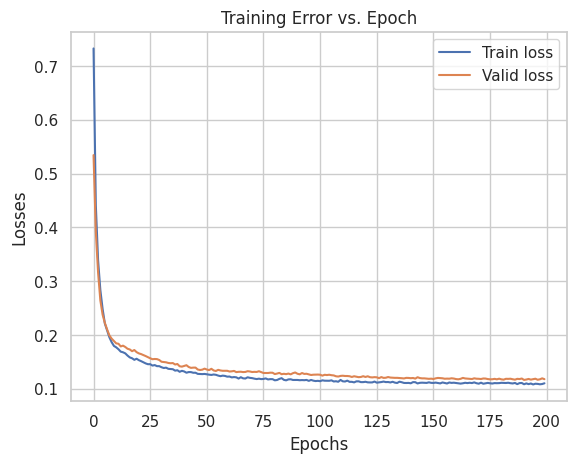

In [40]:
plot(train_losses=linear_train_losses, valid_losses=linear_valid_losses)

---
## Build the Multi-layer Perceptron Base Model

In the following, we build a multi-layer perception model with 2 hidden layers of sizes 256 and 128, respectively and ReLu activations.

In [41]:
# Build a feed-forward network
mlp_model_2 = nn.Sequential(nn.Linear(train_features.shape[1], 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128,1))

Let's print out the model achitecture.

In [42]:
mlp_model_2

Sequential(
  (0): Linear(in_features=122, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [43]:
mlp_model_2 = mlp_model_2.to(device)

In [44]:
#TODO: write code to train the MLP network and save training and validation error.

mlp_train_losses, mlp_valid_losses = train(mlp_model_2, 200, 0.001, criterion_MER, train_loader, valid_loader)


epoch 1 Training loss: 0.24695 Valid_loss: 0.16866
epoch 2 Training loss: 0.17024 Valid_loss: 0.19617
epoch 3 Training loss: 0.16002 Valid_loss: 0.15107
epoch 4 Training loss: 0.14126 Valid_loss: 0.13084
epoch 5 Training loss: 0.14024 Valid_loss: 0.14248
epoch 6 Training loss: 0.13110 Valid_loss: 0.12169
epoch 7 Training loss: 0.12385 Valid_loss: 0.11923
epoch 8 Training loss: 0.12360 Valid_loss: 0.12522
epoch 9 Training loss: 0.11531 Valid_loss: 0.11740
epoch 10 Training loss: 0.11893 Valid_loss: 0.10772
epoch 11 Training loss: 0.11142 Valid_loss: 0.11775
epoch 12 Training loss: 0.11602 Valid_loss: 0.10903
epoch 13 Training loss: 0.11084 Valid_loss: 0.12135
epoch 14 Training loss: 0.10860 Valid_loss: 0.10623
epoch 15 Training loss: 0.10327 Valid_loss: 0.11703
epoch 16 Training loss: 0.10925 Valid_loss: 0.11757
epoch 17 Training loss: 0.10214 Valid_loss: 0.10492
epoch 18 Training loss: 0.10132 Valid_loss: 0.10994
epoch 19 Training loss: 0.10334 Valid_loss: 0.13090
epoch 20 Training los

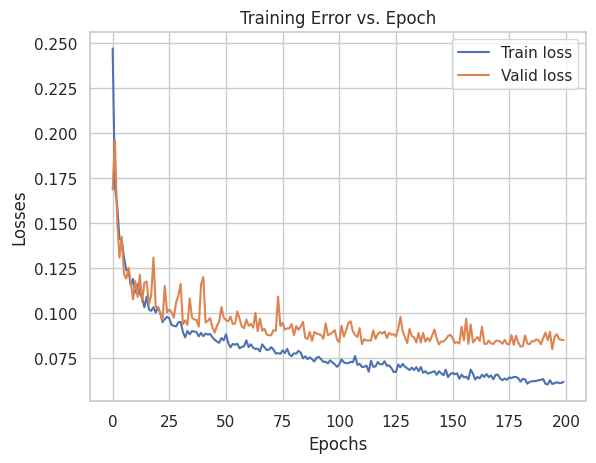

In [45]:
#TODO: Write code to plot the training and validation error (MER) over epochs
plot(mlp_train_losses, mlp_valid_losses)

---
## Change network architecture


In the following, build a MLP with 4 hidden layer of sizes 512, 256, 128, 64, respectively.  

In [46]:
#TODO: building a MLP with 4 hidden layer of sizes 512, 256, 128, 64,
mlp_model = nn.Sequential(nn.Linear(train_features.shape[1], 512),
                      nn.ReLU(),
                      nn.Linear(512, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 1))

mlp_model_4 = mlp_model.to(device)
mlp_model_4


Sequential(
  (0): Linear(in_features=122, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=1, bias=True)
)

epoch 1 Training loss: 0.26606 Valid_loss: 0.19524
epoch 2 Training loss: 0.20428 Valid_loss: 0.18454
epoch 3 Training loss: 0.16629 Valid_loss: 0.14188
epoch 4 Training loss: 0.16258 Valid_loss: 0.16863
epoch 5 Training loss: 0.14648 Valid_loss: 0.14170
epoch 6 Training loss: 0.14125 Valid_loss: 0.15038
epoch 7 Training loss: 0.12443 Valid_loss: 0.17398
epoch 8 Training loss: 0.12689 Valid_loss: 0.12533
epoch 9 Training loss: 0.12142 Valid_loss: 0.11817
epoch 10 Training loss: 0.11405 Valid_loss: 0.12332
epoch 11 Training loss: 0.11629 Valid_loss: 0.13359
epoch 12 Training loss: 0.11653 Valid_loss: 0.12631
epoch 13 Training loss: 0.11329 Valid_loss: 0.12311
epoch 14 Training loss: 0.11446 Valid_loss: 0.11758
epoch 15 Training loss: 0.11398 Valid_loss: 0.10918
epoch 16 Training loss: 0.10632 Valid_loss: 0.10502
epoch 17 Training loss: 0.10839 Valid_loss: 0.10690
epoch 18 Training loss: 0.10438 Valid_loss: 0.09776
epoch 19 Training loss: 0.10688 Valid_loss: 0.09988
epoch 20 Training los

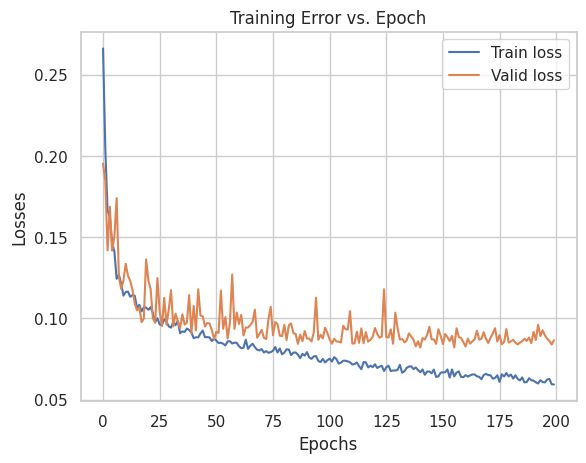

In [47]:
#TODO: plot the training and validation error (MER) over epochs
mlp_train_losses, mlp_valid_losses = train(mlp_model_4, 200, 0.001, criterion_MER, train_loader, valid_loader)
plot(mlp_train_losses, mlp_valid_losses)

---
## Add norm regularization

In the following, use the norm regularization to retrain the above MLP.

epoch 1 Training loss: 0.07768 Valid_loss: 0.09477
epoch 2 Training loss: 0.07731 Valid_loss: 0.09674
epoch 3 Training loss: 0.07666 Valid_loss: 0.09358
epoch 4 Training loss: 0.07880 Valid_loss: 0.10087
epoch 5 Training loss: 0.07630 Valid_loss: 0.09135
epoch 6 Training loss: 0.07892 Valid_loss: 0.09223
epoch 7 Training loss: 0.07696 Valid_loss: 0.09080
epoch 8 Training loss: 0.07765 Valid_loss: 0.09000
epoch 9 Training loss: 0.07507 Valid_loss: 0.10246
epoch 10 Training loss: 0.07721 Valid_loss: 0.09394
epoch 11 Training loss: 0.07566 Valid_loss: 0.08832
epoch 12 Training loss: 0.07265 Valid_loss: 0.08793
epoch 13 Training loss: 0.07450 Valid_loss: 0.09185
epoch 14 Training loss: 0.07437 Valid_loss: 0.08928
epoch 15 Training loss: 0.07758 Valid_loss: 0.08990
epoch 16 Training loss: 0.07655 Valid_loss: 0.09265
epoch 17 Training loss: 0.07692 Valid_loss: 0.08926
epoch 18 Training loss: 0.07503 Valid_loss: 0.09329
epoch 19 Training loss: 0.07668 Valid_loss: 0.08906
epoch 20 Training los

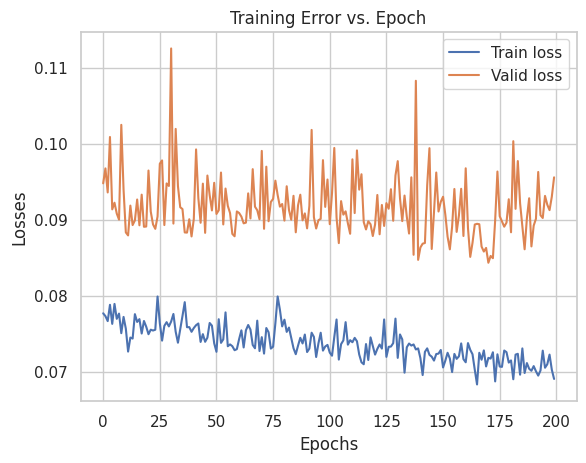

In [48]:
#TODO: plot the training and validation error (MER) over epochs after using norm regularization
mlp_train_losses, mlp_valid_losses = train(mlp_model, 200, 0.001, criterion_MER, train_loader, valid_loader, weight=0.0001)
plot(mlp_train_losses, mlp_valid_losses)

---
## Add dropout layer

In the following, add dropout layer to the above MLP.


epoch 1 Training loss: 0.40255 Valid_loss: 0.20827
epoch 2 Training loss: 0.20744 Valid_loss: 0.18263
epoch 3 Training loss: 0.19121 Valid_loss: 0.16852
epoch 4 Training loss: 0.17567 Valid_loss: 0.19296
epoch 5 Training loss: 0.16301 Valid_loss: 0.15043
epoch 6 Training loss: 0.15591 Valid_loss: 0.14696
epoch 7 Training loss: 0.15359 Valid_loss: 0.13578
epoch 8 Training loss: 0.14478 Valid_loss: 0.13439
epoch 9 Training loss: 0.13979 Valid_loss: 0.12039
epoch 10 Training loss: 0.13725 Valid_loss: 0.12178
epoch 11 Training loss: 0.13783 Valid_loss: 0.12614
epoch 12 Training loss: 0.13085 Valid_loss: 0.11499
epoch 13 Training loss: 0.12805 Valid_loss: 0.11089
epoch 14 Training loss: 0.12939 Valid_loss: 0.10657
epoch 15 Training loss: 0.12587 Valid_loss: 0.12880
epoch 16 Training loss: 0.12597 Valid_loss: 0.13373
epoch 17 Training loss: 0.12411 Valid_loss: 0.10833
epoch 18 Training loss: 0.12403 Valid_loss: 0.11157
epoch 19 Training loss: 0.12070 Valid_loss: 0.10416
epoch 20 Training los

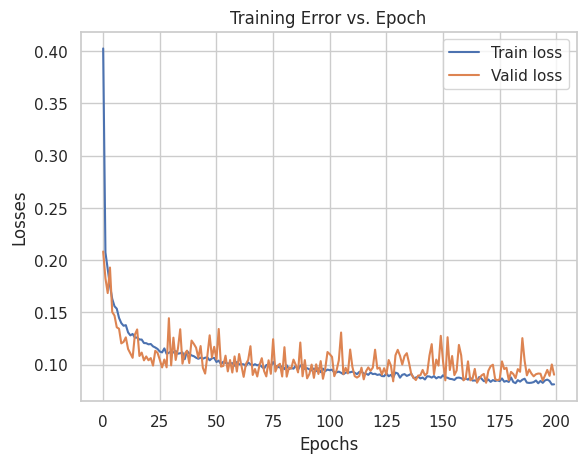

In [51]:
#TODO: plot the training and validation error (MER) over epochs after using norm regularization
class mlp_dropout(nn.Module):
  def __init__(self, input):
    super().__init__()
    self.fc1 = nn.Linear(input, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.output = nn.Linear(64, 1)

    self.dropout = nn.Dropout(p=0.05)

  def forward(self, x):
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = self.dropout(F.relu(self.fc4(x)))
    x = self.dropout(F.relu(self.output(x)))
    return x

mlp_dropout = mlp_dropout(train_features.shape[1])
mlp_dropout.to(device)
mlp_dropout

mlp_train_losses, mlp_valid_losses = train(mlp_dropout, 200, 0.0001, criterion_MER, train_loader, valid_loader)
plot(mlp_train_losses, mlp_valid_losses)

## Some other model variations

**You're more than welcome to try some other model varations (e.g. different number of hidden layers, hidden neurons, learning rate, etc) to achieve lower valid error. Include a table listing all the model hyperparameters that you have tried with the corresponding validation errors that you found.**

In [100]:
dropout_rate = 0.1

mlp_model = nn.Sequential(
    nn.Linear(train_features.shape[1], 256),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(32, 1)
)

mlp_model = mlp_model.to(device)
mlp_model

Sequential(
  (0): Linear(in_features=122, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=128, out_features=128, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=64, out_features=32, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.1, inplace=False)
  (15): Linear(in_features=32, out_features=1, bias=True)
)

---
## Save Model

Save a `checkpoint.pth` file containing all the necessary information to retrieve your best model and predictions. Remember submitting this file to Canvas siste.

Hint: Check out the `Lecture 4 - Saving and Loading Models.ipynb` on Canvas if you do not know how to save model.

HyperTunning Process

In [101]:
def find_optimal_hyperparameters(model, criterion, train_loader, valid_loader, device, epochs_options, lr_options, weight_decay_options=[0]):
    best_val_loss = float('inf')
    best_hyperparameters = None
    best_checkpoint = None

    for weight in weight_decay_options:
        for lr in lr_options:
            for epochs in epochs_options:
                print(f"Training with weight_decay={weight}, lr={lr}, epochs={epochs}")

                trained_model, optimizer, scheduler, train_losses, valid_losses, early_stop = train_dynamic(
                    model, epochs, lr, criterion, train_loader, valid_loader, patience=150, weight=weight
                )

                final_val_loss = valid_losses[-1]
                if final_val_loss < best_val_loss:
                    best_val_loss = final_val_loss
                    best_hyperparameters = {
                        'epoch_size': epochs,
                        'learning_rate': lr,
                        'weight_decay': weight,
                        'early_stop_epoch': len(valid_losses) if early_stop else epochs
                    }
                    # Save the checkpoint
                    best_checkpoint = {
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                        'hyperparameters': best_hyperparameters,
                        'best_val_loss': best_val_loss
                    }
                    torch.save(best_checkpoint, 'checkpoint.pth')

                # Reset the model weights
                model.apply(weight_reset)

    return best_checkpoint

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

### Modify the below variables as an option
epochs_options = [1000] # -> 1000
lr_options = [0.00011] # -> You can add more options. But it will take expontial time to perform it
weight_decay_options = [1e-6] # -> same
criterion = criterion_MER


# Find the optimal set of hyperparameters
best_checkpoint = find_optimal_hyperparameters(
    mlp_model, criterion, train_loader, valid_loader, device,
    epochs_options, lr_options, weight_decay_options
)

print(f"Best hyperparameters:")
for key, value in best_checkpoint['hyperparameters'].items():
    print(f"{key}: {value}")
print(f"Lowest validation loss: {best_checkpoint['best_val_loss']}")


Training with weight_decay=1e-06, lr=0.00011, epochs=1000
Epoch 1/1000 - Training Loss: 0.45359, Validation Loss: 0.23779
Epoch 2/1000 - Training Loss: 0.23065, Validation Loss: 0.20988
Epoch 3/1000 - Training Loss: 0.21429, Validation Loss: 0.17475
Epoch 4/1000 - Training Loss: 0.19462, Validation Loss: 0.16412
Epoch 5/1000 - Training Loss: 0.19161, Validation Loss: 0.15426
Epoch 6/1000 - Training Loss: 0.18813, Validation Loss: 0.19296
Epoch 7/1000 - Training Loss: 0.18029, Validation Loss: 0.14211
Epoch 8/1000 - Training Loss: 0.17445, Validation Loss: 0.13817
Epoch 9/1000 - Training Loss: 0.17261, Validation Loss: 0.14333
Epoch 10/1000 - Training Loss: 0.16736, Validation Loss: 0.14291
Epoch 11/1000 - Training Loss: 0.16284, Validation Loss: 0.12909
Epoch 12/1000 - Training Loss: 0.16254, Validation Loss: 0.14814
Epoch 13/1000 - Training Loss: 0.15880, Validation Loss: 0.12455
Epoch 14/1000 - Training Loss: 0.15814, Validation Loss: 0.12943
Epoch 15/1000 - Training Loss: 0.15757, V

---
## Inference on test data

After the model is trained, we can use it for inference.

In [102]:
model = mlp_model

checkpoint = torch.load('checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()  #Evaluation mode

# Predict the test data
with torch.no_grad():
    predictions = []
    for data in test_loader:
        inputs = data[0].to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
predictions = [item[0] for item in predictions]

denormalized_predictions = [item * normalization_factor for item in predictions]

submission_df = pd.DataFrame({
    "ID": test_ID,
    "SALE_PRICE": denormalized_predictions
})

# Save to a CSV file
submission_csv_path = 'submission.csv'
submission_df.to_csv(submission_csv_path, index=False)


If you want to see the model.pth in detail, change the variable "modelDetail" to True and run the cell

In [103]:
ModelDetail = False #Modify this line

if ModelDetail:
    checkpoint = torch.load('checkpoint.pth')
    model_state_dict = checkpoint['model_state_dict']
    print("Model's state_dict:")
    for param_tensor in model_state_dict:
        print(param_tensor, "\t", model_state_dict[param_tensor].size())

    print("\nParameter values:")
    for param_tensor in model_state_dict:
        print(param_tensor, "\n", model_state_dict[param_tensor])

    # prirnt hyperparameters
    print("\nHyperparameters:")
    for key, value in checkpoint['hyperparameters'].items():
        print(f"{key}: {value}")

    # To print the best validation loss
    print("\nBest Validation Loss:", checkpoint['best_val_loss'])


Model's state_dict:
0.weight 	 torch.Size([256, 122])
0.bias 	 torch.Size([256])
3.weight 	 torch.Size([128, 256])
3.bias 	 torch.Size([128])
6.weight 	 torch.Size([128, 128])
6.bias 	 torch.Size([128])
9.weight 	 torch.Size([64, 128])
9.bias 	 torch.Size([64])
12.weight 	 torch.Size([32, 64])
12.bias 	 torch.Size([32])
15.weight 	 torch.Size([1, 32])
15.bias 	 torch.Size([1])

Parameter values:
0.weight 
 tensor([[ 1.3889e-01, -4.5548e-02, -3.9834e-02,  ...,  7.8615e-03,
          2.0551e-04, -4.9072e-39],
        [ 2.1357e-02,  5.1612e-02, -8.4396e-02,  ...,  5.2598e-02,
          4.4276e-05, -4.9106e-39],
        [-2.4243e-02,  1.8085e-02,  3.5818e-02,  ..., -4.3897e-02,
         -4.9096e-39, -4.9102e-39],
        ...,
        [ 5.6032e-02,  1.9130e-02,  5.7320e-04,  ...,  4.5040e-27,
         -1.5046e-03,  4.9077e-39],
        [ 2.1389e-02,  5.3543e-02,  1.3390e-02,  ...,  5.6854e-03,
          4.9062e-39, -4.9180e-39],
        [-1.1278e-01, -5.2365e-03, -5.3845e-03,  ..., -4.8364e

Now, we can submit our predictions on Kaggle and see how they compare with the actual house prices (labels) on the test set.

- Log in to the Kaggle website and visit the house price prediction competition page.

- Click the “Submit Predictions”.

- Click the “Browse Files” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.

- Click the “Submit” button at the bottom of the page to view your results.

 **Include your best test error shown on Kaggle in your case report!**

---
## Evaluate the profit of iBuyer business model


In class, we have dicussed the iBuyer business model and its opportunities and risks. In the following analysis, imagine you work in a consulting firm and would like to investigate the profitability of the iBuyer business model.

You have taken the Mordern Analytics course and remembered that Prof. X advocated the data-driven approach in business decision making. Thus, you would like to perform analysis based on model and data.

Note that since we do not know the true sale prices in the future (like test data), we need to conduct the analysis based on the historical data (train or validation data). Previously, you have already trained a multilayer perceptron model using the train data. Now, let's evaluate the profit of iBuyer business model based on the predicted prices on the **validation data**.

Let's first compute the predicted prices on the valid data.

In [104]:
## TODO: Load your best model from your saved checkpoint.pth file.
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)
model.eval()

Sequential(
  (0): Linear(in_features=122, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=128, out_features=128, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=64, out_features=32, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.1, inplace=False)
  (15): Linear(in_features=32, out_features=1, bias=True)
)

In [105]:
## TODO: compute the predicted prices on valid data using your best model

predicted_prices = []
actual_prices = []

model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        predicted_prices.extend(outputs.view(-1).tolist())
        actual_prices.extend(labels.view(-1).tolist())

predicted_prices = torch.tensor(predicted_prices)
actual_prices = torch.tensor(actual_prices)

print(predicted_prices, actual_prices)

tensor([3.8492, 3.2493, 7.0268,  ..., 3.1426, 4.3612, 4.1032]) tensor([3.7613, 2.8050, 7.4000,  ..., 3.3997, 4.4200, 3.7400])


Compute the signed error rates (without taking the absolute value sign), that is

$$
\text{Signed Error Rate} = \frac{\text{Predicted Price}-\text{Actual Price}}{\text{Actual Price}}
$$
We will call signed error rate as prediction error henceafter.

In [106]:
## TODO: compute the signed error rates (henceafter called prediction errors)
signed_error_rate = (predicted_prices - actual_prices) / actual_prices

print(signed_error_rate)

tensor([ 0.0234,  0.1584, -0.0504,  ..., -0.0756, -0.0133,  0.0971])


### Analysis and visualization of valid errors

Let's plot the histogram of prediction errors.

**Question 1**: what is the bias of the prediction errors? Include the histogram of prediction errors and the bias in your report.

Bias of the prediction errors: 0.08350742608308792


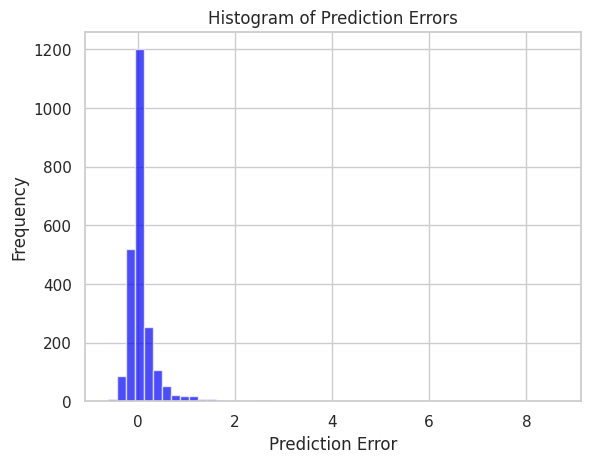

In [107]:
signed_error_rate = signed_error_rate.numpy()


bias = signed_error_rate.mean()
print(f"Bias of the prediction errors: {bias}")

plt.hist(signed_error_rate, bins=50, alpha=0.7, color='blue')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Profit Analysis

In the following profit analysis, we assume the iBuyer will make an offer to every property in the valid data based on their predicted price $PP$. We assume the iBuyer decides the offer price $OP$ according to
$$
OP = \frac{PP}{1+\alpha},
$$
where $\alpha$ is the (targted) profit margin of the iBuyer.
Here we assume the profit margin has already taken into consideration the commission fee charged by the iBuyer
and various costs associated such as transaction cost, administration cost, and holding cost. Note that the commission fee charged by Zillow is often around $7.5\%$ and Zillow may charge additional repair costs after home inspection. Thus we take $\alpha=12\%$ in this case study.

We further assume that the iBuyer can resell the property at the same
price as the broker in the future once the property is bought. In other words, the resell price is equal to the sale price in the valid data. This assumption may not be exactly true in practice and the iBuyer may sell the house at either a higher or lower price depending on the market trend. But our conclusion will not change too much.

Based on the above two assumptions, we can now determine the percentage profit
for a property bought by the iBuyer as
$$
\frac{SP- OP}{OP}.
$$
We use the percentage profit instead of the absolute profit because the iBuyer cannot hope to purchase all houses in the market. Therefore, the percentage profit is a better measure of the profitability of the iBuyer business model.
 The aim of the iBuyer in this simplified setting is to purchase properties for less money than they are sold for, to generate a profit.

In [108]:
profit_margin = 0.12

# Calculate Offer Price (OP)
offer_prices = predicted_prices / (1 + profit_margin)
# Calculate Percentage Profit
percentage_profit = (actual_prices - offer_prices) / offer_prices


# Convert percentage_profit to a numpy array for analysis
percentage_profit = percentage_profit.numpy()
print(percentage_profit)

[ 0.09442388 -0.03314828  0.17948507 ...  0.2116554   0.1350981
  0.02085428]


**Question 2**: Consider the hypothetical scenario where the offers are all accepted regardless of their values,
what is the average percentage profit? Do you see a big difference compared to the profit margin $\alpha$? Include your answers in the report.

In [109]:
# Calculate the average percentage profit
average_percentage_profit = percentage_profit.mean()
print(f"Average Percentage Profit: {average_percentage_profit * 100:.2f}%")

Average Percentage Profit: 9.92%


**Offer Acceptance Rule**


However, not every offer will be accepted by the home owner. Given an offer price, whether the homeowner accepts it
depends on the homeowner's perceived valuation. For the current dataset, we lack enough data to determine the homeowner's perceived valuation of the property. However, the actual sale price in the valid data serves as a reasonable proxy of the homeowner's perceived valuation. Therefore, we assume that the home owner will accept the offer, if
$$
OP> (1-\beta) SP,
$$
where $\beta$ is a discounting factor. Here the discounting factor captures the commission fee charged
by the conventional realtors which is around 6%, as well as the convenience factor that models
how much the homeowner values the quick transaction services of the iBuyer over the conventional
relator. We assume $\beta = 10\%$ in this case.

**Question 3**: Based on the sale price in the valid data and the acceptance rule, what is the mean percentage profit among all accepted offers? Do you see a big difference compared to the targeted profit margin $\alpha$?  Include your answers in your report.  

In [110]:
discount_factor = 0.10

accepted_offers = offer_prices > (1 - discount_factor) * actual_prices

# Calculate mean percentage profit for accepted offers
mean_profit_accepted = percentage_profit[accepted_offers].mean()
print(f"Mean Percentage Profit for Accepted Offers: {mean_profit_accepted * 100:.2f}%")


Mean Percentage Profit for Accepted Offers: -5.57%


Find the break even point in term of the profit

In [111]:
closest_to_zero = float('inf')  # Initialize with a large number
break_even_discount_factor = 0

for discount_factor in [i * 0.01 for i in range(100)]:
    accepted_offers = offer_prices > (1 - discount_factor) * actual_prices
    mean_profit_accepted = percentage_profit[accepted_offers].mean()
    if abs(mean_profit_accepted) < closest_to_zero:
        closest_to_zero = abs(mean_profit_accepted)
        break_even_discount_factor = discount_factor
    if closest_to_zero == 0:
        break

print(f"Break-even discount factor: {break_even_discount_factor * 100:.2f}%")


Break-even discount factor: 14.00%


Let's plot the histogram of the prediction errors for those properties whose home owners accepted the offer.

**Question 4**: What is the bias of the prediction errors when restricting to those properties whose owners accepted the offer? Based on the histogram and bias, can you explain your answers to Question 3?

Bias of Prediction Errors for Accepted Offers: -0.14073200523853302


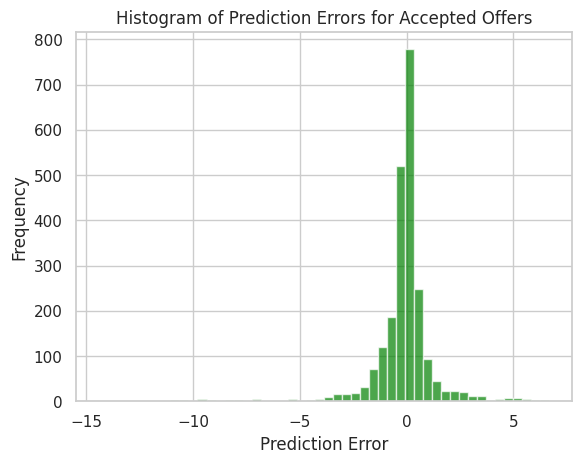

In [112]:
prediction_error = actual_prices - predicted_prices
prediction_errors_accepted = prediction_error[accepted_offers]

bias_accepted = prediction_errors_accepted.mean()
print(f"Bias of Prediction Errors for Accepted Offers: {bias_accepted}")

plt.hist(prediction_errors_accepted, bins=50, alpha=0.7, color='green')
plt.title('Histogram of Prediction Errors for Accepted Offers')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
